In [1]:
%cd 'python/AggNet'
%ls

/home/hew/python/AggNet
cache/  data/  framework/  main.py  script/  temp/


# ESM2 example

In [2]:
import esm
import torch

In [3]:
model, alphabet = esm.pretrained.esm2_t33_650M_UR50D()
len(alphabet.all_toks), alphabet.all_toks

(33,
 ['<cls>',
  '<pad>',
  '<eos>',
  '<unk>',
  'L',
  'A',
  'G',
  'V',
  'S',
  'E',
  'R',
  'T',
  'I',
  'D',
  'P',
  'K',
  'Q',
  'N',
  'F',
  'Y',
  'M',
  'H',
  'W',
  'C',
  'X',
  'B',
  'U',
  'Z',
  'O',
  '.',
  '-',
  '<null_1>',
  '<mask>'])

Transferred model to GPU


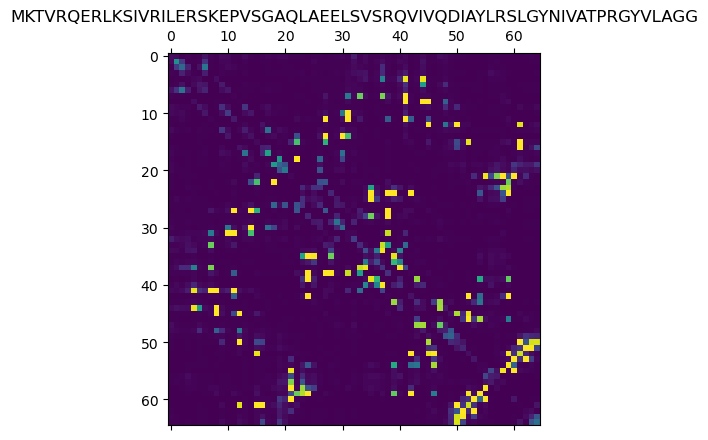

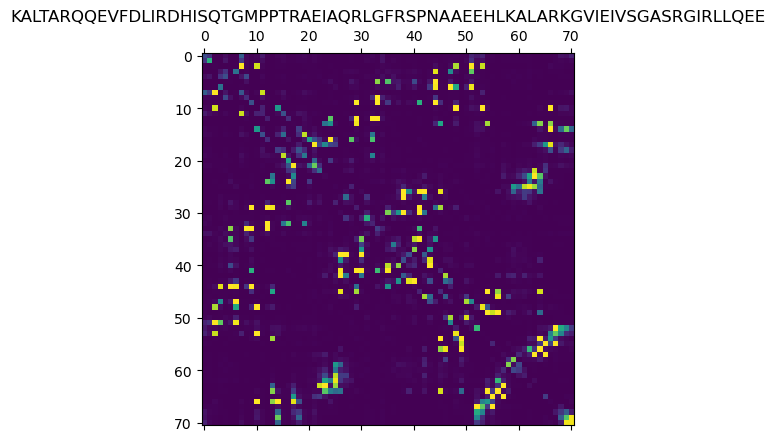

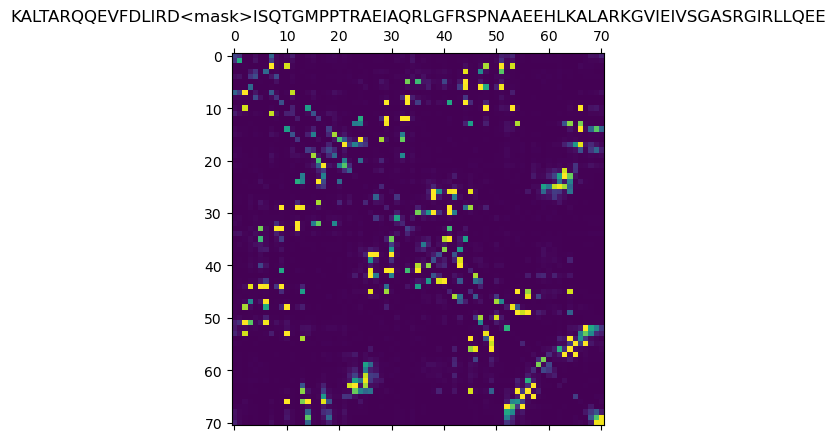

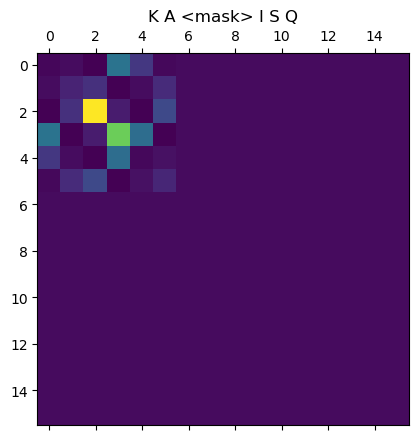

CPU times: user 29.5 s, sys: 11 s, total: 40.5 s
Wall time: 12.2 s


In [4]:
%%time
# Load ESM-2 model
model, alphabet = esm.pretrained.esm2_t33_650M_UR50D()
# model, alphabet = esm.pretrained.esm2_t48_15B_UR50D()
batch_converter = alphabet.get_batch_converter()
model.eval()  # disables dropout for deterministic results

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
print("Transferred model to GPU")

# Prepare data (first 2 sequences from ESMStructuralSplitDataset superfamily / 4)
data = [
    ("protein1", "MKTVRQERLKSIVRILERSKEPVSGAQLAEELSVSRQVIVQDIAYLRSLGYNIVATPRGYVLAGG"),
    ("protein2", "KALTARQQEVFDLIRDHISQTGMPPTRAEIAQRLGFRSPNAAEEHLKALARKGVIEIVSGASRGIRLLQEE"),
    ("protein2 with mask", "KALTARQQEVFDLIRD<mask>ISQTGMPPTRAEIAQRLGFRSPNAAEEHLKALARKGVIEIVSGASRGIRLLQEE"),
    ("protein3", "K A <mask> I S Q"),
]
batch_labels, batch_strs, batch_tokens = batch_converter(data)

# Extract per-residue representations (on CPU)
with torch.no_grad():
    results = model(batch_tokens.to(device), repr_layers=[32, 33], return_contacts=True)
token_representations = results["representations"][33]

# Generate per-sequence representations via averaging
# NOTE: token 0 is always a beginning-of-sequence token, so the first residue is token 1.
sequence_representations = []
for i, (_, seq) in enumerate(data):
    sequence_representations.append(token_representations[i, 1: len(seq) + 1].mean(0))

# Look at the unsupervised self-attention map contact predictions
import matplotlib.pyplot as plt

for (_, seq), attention_contacts in zip(data, results["contacts"].cpu()):
    plt.matshow(attention_contacts[: len(seq), : len(seq)])
    plt.title(seq)
    plt.show()

In [5]:
batch_labels

['protein1', 'protein2', 'protein2 with mask', 'protein3']

In [6]:
batch_strs, [len(x) for x in batch_strs]

(['MKTVRQERLKSIVRILERSKEPVSGAQLAEELSVSRQVIVQDIAYLRSLGYNIVATPRGYVLAGG',
  'KALTARQQEVFDLIRDHISQTGMPPTRAEIAQRLGFRSPNAAEEHLKALARKGVIEIVSGASRGIRLLQEE',
  'KALTARQQEVFDLIRD<mask>ISQTGMPPTRAEIAQRLGFRSPNAAEEHLKALARKGVIEIVSGASRGIRLLQEE',
  'K A <mask> I S Q'],
 [65, 71, 76, 16])

In [7]:
batch_tokens.shape, batch_tokens

(torch.Size([4, 73]),
 tensor([[ 0, 20, 15, 11,  7, 10, 16,  9, 10,  4, 15,  8, 12,  7, 10, 12,  4,  9,
          10,  8, 15,  9, 14,  7,  8,  6,  5, 16,  4,  5,  9,  9,  4,  8,  7,  8,
          10, 16,  7, 12,  7, 16, 13, 12,  5, 19,  4, 10,  8,  4,  6, 19, 17, 12,
           7,  5, 11, 14, 10,  6, 19,  7,  4,  5,  6,  6,  2,  1,  1,  1,  1,  1,
           1],
         [ 0, 15,  5,  4, 11,  5, 10, 16, 16,  9,  7, 18, 13,  4, 12, 10, 13, 21,
          12,  8, 16, 11,  6, 20, 14, 14, 11, 10,  5,  9, 12,  5, 16, 10,  4,  6,
          18, 10,  8, 14, 17,  5,  5,  9,  9, 21,  4, 15,  5,  4,  5, 10, 15,  6,
           7, 12,  9, 12,  7,  8,  6,  5,  8, 10,  6, 12, 10,  4,  4, 16,  9,  9,
           2],
         [ 0, 15,  5,  4, 11,  5, 10, 16, 16,  9,  7, 18, 13,  4, 12, 10, 13, 32,
          12,  8, 16, 11,  6, 20, 14, 14, 11, 10,  5,  9, 12,  5, 16, 10,  4,  6,
          18, 10,  8, 14, 17,  5,  5,  9,  9, 21,  4, 15,  5,  4,  5, 10, 15,  6,
           7, 12,  9, 12,  7,  8,  6,  5,  8, 

In [8]:
results.keys()

dict_keys(['logits', 'representations', 'attentions', 'contacts'])

In [9]:
results['logits'].size(), results['attentions'].size(), results['contacts'].size()

(torch.Size([4, 73, 33]),
 torch.Size([4, 33, 20, 73, 73]),
 torch.Size([4, 71, 71]))

In [10]:
results['representations'].keys(), results['representations'][33].size()

(dict_keys([32, 33]), torch.Size([4, 73, 1280]))

# Keep model in memory

In [11]:
import torch
import esm
import numpy as np
import matplotlib.pyplot as plt

In [12]:
%%time
# Load ESM-2 model
model, alphabet = esm.pretrained.esm2_t33_650M_UR50D()
# model, alphabet = esm.pretrained.esm2_t48_15B_UR50D()
batch_converter = alphabet.get_batch_converter()
model.eval()  # disables dropout for deterministic results

# device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device = 'cpu'
model = model.to(device)
print("Transferred model to GPU")

Transferred model to GPU
CPU times: user 19.6 s, sys: 7.69 s, total: 27.3 s
Wall time: 8.36 s


In [13]:
WFL = 'QVQLVQSGAEVKKPGSSVKVSCKASGGTFWFGAFTWVRQAPGQGLEWMGGIIPIFGLTNLAQNFQGRVTITADESTSTVYMELSSLRSEDTAVYYCARSSRIYDLNPSLTAYYDMDVWGQGTMVTVSSGGGSSGGGGSGGGGGAQSVLTQPPSVSAAPGQKVTISCSGSSSDIGNNYVSWYQQLPGTAPKLLIYDNNKRPSGIPDRFSGSKSGTSATLGITGLQTGDEADYYCGTWDSSLSAWVFGGGTKLTVL'

STT = 'QVQLVQSGAEVKKPGSSVKVSCKASGGTFSTGAFTWVRQAPGQGLEWMGGIIPIFGTTNLAQNFQGRVTITADESTSTVYMELSSLRSEDTAVYYCARSSRIYDLNPSLTAYYDMDVWGQGTMVTVSSGGGSSGGGGSGGGGGAQSVLTQPPSVSAAPGQKVTISCSGSSSDIGNNYVSWYQQLPGTAPKLLIYDNNKRPSGIPDRFSGSKSGTSATLGITGLQTGDEADYYCGTWDSSLSAWVFGGGTKLTVL'

len(WFL), len(STT)

(254, 254)

In [14]:
np.where(np.array(list(WFL)) != np.array(list(STT)))

(array([29, 30, 56]),)

In [15]:
%%time
data = [("WFL", WFL), ("STT", STT)]
# data = [("peptide", "KALTAR")] * 10240
batch_labels, batch_strs, batch_tokens = batch_converter(data)

# Extract per-residue representations (on CPU)
with torch.no_grad():
    results = model(batch_tokens.to(device), repr_layers=[32, 33], return_contacts=True)
token_representations = results["representations"][33]

CPU times: user 47.2 s, sys: 42.2 s, total: 1min 29s
Wall time: 3.26 s


In [16]:
results["representations"][33].shape, results['contacts'].shape

(torch.Size([2, 256, 1280]), torch.Size([2, 254, 254]))

In [17]:
(results['contacts'].flatten() >= 0).all(), (results['contacts'].flatten() <= 1.0).all(), (
        results['contacts'].flatten() <= 0.9).all()

(tensor(True), tensor(True), tensor(False))

In [18]:
scores = results['contacts'].flatten()[results['contacts'].flatten() > 0.1]

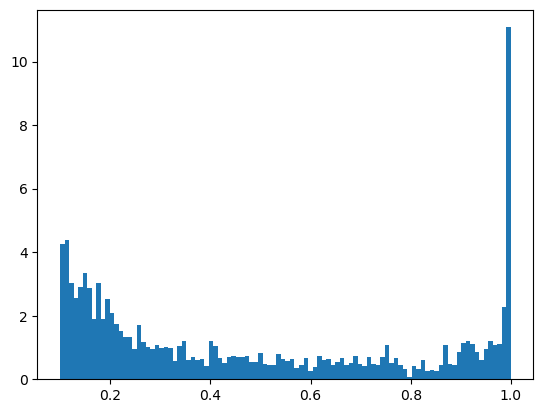

In [19]:
fig = plt.hist(scores, density=True, bins=100)

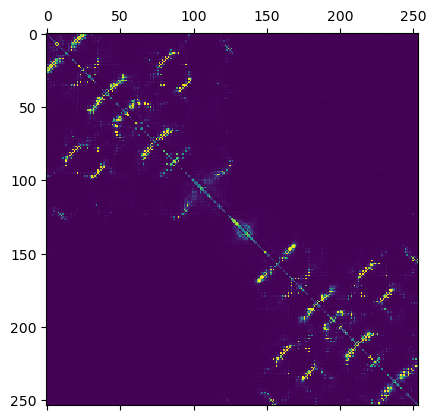

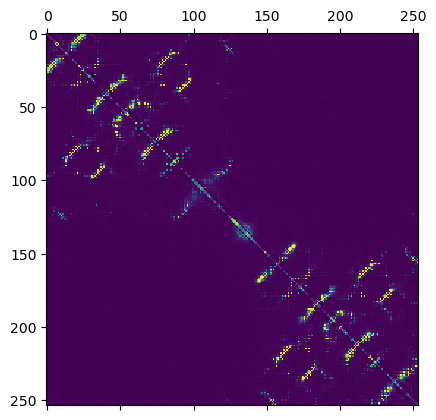

In [20]:
for (_, seq), attention_contacts in zip(data, results["contacts"].cpu()):
    plt.matshow(attention_contacts[: len(seq), : len(seq)])
    plt.show()

In [21]:
# 给定residue index,根据contact找到k个最近的residue的idx
idx = 2
k = 16

contacts = results['contacts'][0, idx]  # (L, ).cpu().numpy()
topk = torch.topk(contacts, k=k, dim=0)  # 找到k个最近的residue的idx
topk

torch.return_types.topk(
values=tensor([1.0000, 0.9714, 0.8971, 0.7126, 0.2918, 0.1568, 0.1297, 0.0656, 0.0609,
        0.0527, 0.0476, 0.0411, 0.0343, 0.0331, 0.0309, 0.0270]),
indices=tensor([24, 22, 25, 23,  2, 21, 26,  9,  7, 20, 19, 12, 10, 27, 18,  8]))

In [22]:
topk.indices

tensor([24, 22, 25, 23,  2, 21, 26,  9,  7, 20, 19, 12, 10, 27, 18,  8])

In [23]:
results['contacts'][0, idx, topk.indices]

tensor([1.0000, 0.9714, 0.8971, 0.7126, 0.2918, 0.1568, 0.1297, 0.0656, 0.0609,
        0.0527, 0.0476, 0.0411, 0.0343, 0.0331, 0.0309, 0.0270])

In [24]:
contacts = results['contacts']  # (B, L, L)
topk_tensors = torch.topk(results['contacts'], k=k, dim=-1).indices  # (B, L, k)
topk_tensors, topk_tensors.shape

(tensor([[[ 25,  24,  26,  ...,  12,  28,  41],
          [ 25,  23,  24,  ...,  37,  99,  29],
          [ 24,  22,  25,  ...,  27,  18,   8],
          ...,
          [154, 152, 251,  ..., 153, 183, 224],
          [227, 222, 155,  ..., 158, 184, 219],
          [154, 253, 156,  ..., 159, 225, 245]],
 
         [[ 25,  24,  26,  ...,  19,  29, 134],
          [ 25,  23,  24,  ...,  99,  29,  37],
          [ 24,  22,  25,  ...,  18,  10,   8],
          ...,
          [154, 152, 251,  ..., 244, 183, 224],
          [227, 222, 155,  ..., 158, 184, 125],
          [154, 156, 253,  ..., 159, 225, 245]]]),
 torch.Size([2, 254, 16]))

In [25]:
min(topk_tensors.flatten()), max(topk_tensors.flatten())

(tensor(0), tensor(253))

In [26]:
results["representations"][33].shape, results["representations"][33][:, 1:-1, :].shape, topk_tensors.shape

(torch.Size([2, 256, 1280]),
 torch.Size([2, 254, 1280]),
 torch.Size([2, 254, 16]))

In [27]:
representations = torch.arange(0, 254).unsqueeze(0).unsqueeze(-1).expand(2, -1, 1280)
representations.shape, representations

(torch.Size([2, 254, 1280]),
 tensor([[[  0,   0,   0,  ...,   0,   0,   0],
          [  1,   1,   1,  ...,   1,   1,   1],
          [  2,   2,   2,  ...,   2,   2,   2],
          ...,
          [251, 251, 251,  ..., 251, 251, 251],
          [252, 252, 252,  ..., 252, 252, 252],
          [253, 253, 253,  ..., 253, 253, 253]],
 
         [[  0,   0,   0,  ...,   0,   0,   0],
          [  1,   1,   1,  ...,   1,   1,   1],
          [  2,   2,   2,  ...,   2,   2,   2],
          ...,
          [251, 251, 251,  ..., 251, 251, 251],
          [252, 252, 252,  ..., 252, 252, 252],
          [253, 253, 253,  ..., 253, 253, 253]]]))

In [28]:
topk_tensors_expanded = topk_tensors.unsqueeze(-1).expand(-1, -1, -1, 1280)
topk_tensors_expanded.shape, topk_tensors_expanded

(torch.Size([2, 254, 16, 1280]),
 tensor([[[[ 25,  25,  25,  ...,  25,  25,  25],
           [ 24,  24,  24,  ...,  24,  24,  24],
           [ 26,  26,  26,  ...,  26,  26,  26],
           ...,
           [ 12,  12,  12,  ...,  12,  12,  12],
           [ 28,  28,  28,  ...,  28,  28,  28],
           [ 41,  41,  41,  ...,  41,  41,  41]],
 
          [[ 25,  25,  25,  ...,  25,  25,  25],
           [ 23,  23,  23,  ...,  23,  23,  23],
           [ 24,  24,  24,  ...,  24,  24,  24],
           ...,
           [ 37,  37,  37,  ...,  37,  37,  37],
           [ 99,  99,  99,  ...,  99,  99,  99],
           [ 29,  29,  29,  ...,  29,  29,  29]],
 
          [[ 24,  24,  24,  ...,  24,  24,  24],
           [ 22,  22,  22,  ...,  22,  22,  22],
           [ 25,  25,  25,  ...,  25,  25,  25],
           ...,
           [ 27,  27,  27,  ...,  27,  27,  27],
           [ 18,  18,  18,  ...,  18,  18,  18],
           [  8,   8,   8,  ...,   8,   8,   8]],
 
          ...,
 
          [

In [29]:
# 根据topk_tensors(B, L, k)从representations(B, L, 1280)中找到对应的representations得到的是(B, L, k, 1280)
representations = results["representations"][33][:, 1:-1, :]
topk_tensors_expanded = topk_tensors.unsqueeze(-1).expand(-1, -1, -1, 1280)
topk_representations = torch.gather(representations.unsqueeze(2).expand(-1, -1, k, -1), 1, topk_tensors_expanded)
topk_representations.shape

torch.Size([2, 254, 16, 1280])

In [30]:
representations = results["representations"][33][:, 1:-1, :]
topk_tensors_expanded = topk_tensors.unsqueeze(-1).repeat(1, 1, 1, 1280)
topk_representations = torch.gather(representations.unsqueeze(2).repeat(1, 1, k, 1), 1, topk_tensors_expanded)
topk_representations.shape

torch.Size([2, 254, 16, 1280])

In [31]:
topk_representations

tensor([[[[ 0.1236, -0.0735,  0.1016,  ..., -0.2581,  0.0702, -0.0950],
          [ 0.1334,  0.4056, -0.0604,  ..., -0.0533, -0.2877,  0.2218],
          [ 0.1136, -0.3525, -0.4596,  ..., -0.3878, -0.0423,  0.1880],
          ...,
          [-0.0602, -0.0207, -0.1262,  ...,  0.1438, -0.0432,  0.2367],
          [ 0.0511, -0.0083,  0.1816,  ..., -0.8026,  0.2624,  0.0492],
          [-0.1816,  0.1226, -0.2630,  ..., -0.3646,  0.2067,  0.3697]],

         [[ 0.1236, -0.0735,  0.1016,  ..., -0.2581,  0.0702, -0.0950],
          [-0.1976,  0.2113,  0.1263,  ..., -0.5900,  0.2314,  0.1226],
          [ 0.1334,  0.4056, -0.0604,  ..., -0.0533, -0.2877,  0.2218],
          ...,
          [-0.0946, -0.0271, -0.1145,  ..., -0.2493,  0.3042,  0.3497],
          [ 0.1254,  0.2625, -0.1513,  ..., -0.3006,  0.3753, -0.0278],
          [-0.0289, -0.2553, -0.1223,  ..., -0.2683,  0.1562, -0.3753]],

         [[ 0.1334,  0.4056, -0.0604,  ..., -0.0533, -0.2877,  0.2218],
          [ 0.1531, -0.0389, -

In [32]:
topk_representations[:, 28]

tensor([[[-0.1976,  0.2113,  0.1263,  ..., -0.5900,  0.2314,  0.1226],
         [-0.3477, -0.0846, -0.3149,  ..., -0.3093, -0.0627, -0.2058],
         [ 0.1558, -0.0897,  0.0174,  ..., -0.3393, -0.0561,  0.2704],
         ...,
         [ 0.1805,  0.0370,  0.0301,  ...,  0.1600,  0.2718,  0.1611],
         [-0.0611,  0.0256,  0.2311,  ..., -0.5217,  0.2270, -0.1425],
         [-0.1184, -0.2072, -0.0103,  ..., -0.1024,  0.2266, -0.1101]],

        [[-0.2042,  0.1435,  0.1157,  ..., -0.5321,  0.2204,  0.1188],
         [-0.0902, -0.0712, -0.0607,  ..., -0.0102,  0.0256, -0.0014],
         [ 0.2120, -0.0859, -0.0019,  ..., -0.3359, -0.1008,  0.2386],
         ...,
         [ 0.1745,  0.0266,  0.0263,  ...,  0.1697,  0.2666,  0.1262],
         [-0.0609,  0.0411,  0.2434,  ..., -0.5130,  0.2261, -0.1549],
         [ 0.1408, -0.0241, -0.2435,  ..., -0.4660,  0.1096,  0.0602]]])

In [33]:
topk_representations[:, 29]

tensor([[[ 0.1558, -0.0897,  0.0174,  ..., -0.3393, -0.0561,  0.2704],
         [-0.0008, -0.0937, -0.0710,  ..., -0.2974, -0.1035, -0.2365],
         [-0.0289, -0.2553, -0.1223,  ..., -0.2683,  0.1562, -0.3753],
         ...,
         [-0.2117, -0.0421, -0.1390,  ..., -0.2014,  0.0401,  0.0261],
         [-0.3811,  0.1065, -0.2217,  ..., -0.5767, -0.0681,  0.2234],
         [-0.0860, -0.2372, -0.3928,  ...,  0.2213, -0.3351, -0.0122]],

        [[ 0.2120, -0.0859, -0.0019,  ..., -0.3359, -0.1008,  0.2386],
         [ 0.0827, -0.2228, -0.1415,  ..., -0.1527,  0.1050, -0.4297],
         [-0.2013, -0.0979, -0.1492,  ..., -0.3129, -0.1052, -0.2906],
         ...,
         [ 0.0074,  0.2270, -0.0867,  ..., -0.3353,  0.0164, -0.0410],
         [-0.1992,  0.0044, -0.1492,  ..., -0.2162,  0.0694,  0.0007],
         [-0.3780,  0.0995, -0.2362,  ..., -0.5656, -0.0948,  0.2093]]])

In [34]:
topk_tensors[:, [28, 29, 30, 31, 56]]

tensor([[[23, 33, 52, 78, 28, 73, 97, 71, 76, 29, 50, 22, 21,  1, 98, 53],
         [52, 30, 29, 53, 28, 23, 73, 54, 76, 71, 55, 51, 97, 58, 21, 74],
         [52, 53, 54, 29, 30, 97, 73, 51, 98, 49, 55, 21, 99, 23, 58, 56],
         [97, 98, 52, 31, 99, 51, 32, 53, 49,  1, 30, 95, 73, 54, 23, 50],
         [55, 56, 49, 30, 50, 32, 48, 53, 64, 29, 51, 46, 71, 70, 74, 62]],

        [[23, 78, 52, 33, 73, 28, 71, 76, 97, 29, 50, 21, 59,  1, 98, 22],
         [52, 29, 30, 28, 23, 73, 76, 53, 54, 97, 71, 55, 74, 51, 58, 21],
         [52, 29, 53, 30, 54, 97, 73, 49, 98, 51, 99, 21, 55, 71, 23, 31],
         [97, 98, 52, 31, 99, 51, 49, 73, 32, 53, 95,  1, 30, 23, 54, 50],
         [55, 56, 49, 50, 32, 48, 30, 53, 51, 46, 64, 29, 70, 71, 33, 31]]])

In [35]:
idx = 28
set(topk_tensors[0, idx].tolist()) - set(topk_tensors[1, idx].tolist()), set(topk_tensors[1, idx].tolist()) - set(
    topk_tensors[0, idx].tolist())

({53}, {59})

In [36]:
idx = 29
set(topk_tensors[0, idx].tolist()) - set(topk_tensors[1, idx].tolist()), set(topk_tensors[1, idx].tolist()) - set(
    topk_tensors[0, idx].tolist())

(set(), set())

In [37]:
idx = 30
set(topk_tensors[0, idx].tolist()) - set(topk_tensors[1, idx].tolist()), set(topk_tensors[1, idx].tolist()) - set(
    topk_tensors[0, idx].tolist())

({56, 58}, {31, 71})

In [38]:
idx = 31
set(topk_tensors[0, idx].tolist()) - set(topk_tensors[1, idx].tolist()), set(topk_tensors[1, idx].tolist()) - set(
    topk_tensors[0, idx].tolist())

(set(), set())

In [39]:
idx = 56
set(topk_tensors[0, idx].tolist()) - set(topk_tensors[1, idx].tolist()), set(topk_tensors[1, idx].tolist()) - set(
    topk_tensors[0, idx].tolist())

({62, 74}, {31, 33})

In [40]:
topk_representations[:, 29, :5]

tensor([[[ 0.1558, -0.0897,  0.0174,  ..., -0.3393, -0.0561,  0.2704],
         [-0.0008, -0.0937, -0.0710,  ..., -0.2974, -0.1035, -0.2365],
         [-0.0289, -0.2553, -0.1223,  ..., -0.2683,  0.1562, -0.3753],
         [-0.1184, -0.2072, -0.0103,  ..., -0.1024,  0.2266, -0.1101],
         [ 0.0511, -0.0083,  0.1816,  ..., -0.8026,  0.2624,  0.0492]],

        [[ 0.2120, -0.0859, -0.0019,  ..., -0.3359, -0.1008,  0.2386],
         [ 0.0827, -0.2228, -0.1415,  ..., -0.1527,  0.1050, -0.4297],
         [-0.2013, -0.0979, -0.1492,  ..., -0.3129, -0.1052, -0.2906],
         [ 0.0490, -0.0773,  0.2218,  ..., -0.8058,  0.1574,  0.0319],
         [-0.2042,  0.1435,  0.1157,  ..., -0.5321,  0.2204,  0.1188]]])

In [41]:
topk_tensors[:, 29, :5]

tensor([[52, 30, 29, 53, 28],
        [52, 29, 30, 28, 23]])

In [42]:
topk_representations.shape, topk_tensors.shape

(torch.Size([2, 254, 16, 1280]), torch.Size([2, 254, 16]))

In [43]:
contacts.shape

torch.Size([2, 254, 254])

In [44]:
positions = torch.tensor([28, 29])
positions

tensor([28, 29])

In [45]:
mutation_positions = positions.view(-1, 1, 1).repeat(1, 1, contacts.shape[-1])  # (2N, 1, L)
mutation_positions, mutation_positions.shape

(tensor([[[28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28,
           28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28,
           28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28,
           28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28,
           28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28,
           28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28,
           28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28,
           28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28,
           28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28,
           28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28,
           28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28,
           28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28,
           28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 2

In [46]:
esm_contacts = torch.gather(contacts, 1, mutation_positions).squeeze(1)  # (2N, L)
esm_contacts, esm_contacts.shape

(tensor([[1.8007e-02, 4.7064e-02, 1.4739e-02, 3.2761e-02, 8.1018e-03, 2.5012e-02,
          8.5084e-03, 7.9728e-03, 6.5763e-03, 8.0574e-03, 8.1315e-03, 5.6562e-03,
          7.7044e-03, 6.6429e-03, 3.0679e-03, 5.6134e-03, 8.1743e-03, 1.1614e-02,
          1.1083e-02, 1.5419e-02, 1.1750e-02, 5.1944e-02, 5.3942e-02, 9.9794e-01,
          7.5533e-03, 1.4125e-03, 6.3788e-06, 2.9362e-03, 4.6124e-01, 1.5372e-01,
          1.0100e-04, 2.1730e-03, 4.7833e-03, 8.1248e-01, 2.9555e-02, 2.2551e-02,
          6.0844e-03, 2.4821e-02, 7.2387e-03, 2.4090e-02, 8.3969e-03, 7.9441e-03,
          6.4809e-03, 8.0170e-03, 1.3447e-02, 6.7775e-03, 1.0453e-02, 7.0847e-03,
          1.4917e-02, 2.5764e-02, 9.1978e-02, 2.5121e-02, 7.8815e-01, 4.0722e-02,
          2.6620e-02, 2.7286e-02, 1.4179e-02, 2.5235e-02, 1.8505e-02, 3.8898e-02,
          1.6873e-02, 1.5330e-02, 1.0983e-02, 1.2430e-02, 1.0101e-02, 6.5789e-03,
          6.3174e-03, 5.8395e-03, 6.5464e-03, 3.0304e-02, 6.8008e-03, 3.5194e-01,
          6.9096

In [47]:
knn_indices = torch.topk(esm_contacts, k=k, dim=-1).indices  # (2N, L, k)
knn_indices, knn_indices.shape

(tensor([[23, 33, 52, 78, 28, 73, 97, 71, 76, 29, 50, 22, 21,  1, 98, 53],
         [52, 29, 30, 28, 23, 73, 76, 53, 54, 97, 71, 55, 74, 51, 58, 21]]),
 torch.Size([2, 16]))

In [48]:
knn_positions = knn_indices.unsqueeze(-1).repeat(1, 1, 1280)
knn_positions, knn_positions.shape

(tensor([[[23, 23, 23,  ..., 23, 23, 23],
          [33, 33, 33,  ..., 33, 33, 33],
          [52, 52, 52,  ..., 52, 52, 52],
          ...,
          [ 1,  1,  1,  ...,  1,  1,  1],
          [98, 98, 98,  ..., 98, 98, 98],
          [53, 53, 53,  ..., 53, 53, 53]],
 
         [[52, 52, 52,  ..., 52, 52, 52],
          [29, 29, 29,  ..., 29, 29, 29],
          [30, 30, 30,  ..., 30, 30, 30],
          ...,
          [51, 51, 51,  ..., 51, 51, 51],
          [58, 58, 58,  ..., 58, 58, 58],
          [21, 21, 21,  ..., 21, 21, 21]]]),
 torch.Size([2, 16, 1280]))

In [50]:
residue_embeddings = torch.arange(0, 6).view(-1, 1, 1).repeat(1, 4, 3).unsqueeze(0).expand(2, -1, -1, -1)
residue_embeddings, residue_embeddings.shape

(tensor([[[[0, 0, 0],
           [0, 0, 0],
           [0, 0, 0],
           [0, 0, 0]],
 
          [[1, 1, 1],
           [1, 1, 1],
           [1, 1, 1],
           [1, 1, 1]],
 
          [[2, 2, 2],
           [2, 2, 2],
           [2, 2, 2],
           [2, 2, 2]],
 
          [[3, 3, 3],
           [3, 3, 3],
           [3, 3, 3],
           [3, 3, 3]],
 
          [[4, 4, 4],
           [4, 4, 4],
           [4, 4, 4],
           [4, 4, 4]],
 
          [[5, 5, 5],
           [5, 5, 5],
           [5, 5, 5],
           [5, 5, 5]]],
 
 
         [[[0, 0, 0],
           [0, 0, 0],
           [0, 0, 0],
           [0, 0, 0]],
 
          [[1, 1, 1],
           [1, 1, 1],
           [1, 1, 1],
           [1, 1, 1]],
 
          [[2, 2, 2],
           [2, 2, 2],
           [2, 2, 2],
           [2, 2, 2]],
 
          [[3, 3, 3],
           [3, 3, 3],
           [3, 3, 3],
           [3, 3, 3]],
 
          [[4, 4, 4],
           [4, 4, 4],
           [4, 4, 4],
           [4, 4, 4]]

In [51]:
residue_embeddings = residue_embeddings[:, :, 0]
residue_embeddings, residue_embeddings.shape

(tensor([[[0, 0, 0],
          [1, 1, 1],
          [2, 2, 2],
          [3, 3, 3],
          [4, 4, 4],
          [5, 5, 5]],
 
         [[0, 0, 0],
          [1, 1, 1],
          [2, 2, 2],
          [3, 3, 3],
          [4, 4, 4],
          [5, 5, 5]]]),
 torch.Size([2, 6, 3]))

In [52]:
positions = torch.tensor([0, 1])
mutation_sites = positions.view(-1, 1, 1, 1).repeat(1, 1, 4, 3)
mutation_sites, mutation_sites.shape

(tensor([[[[0, 0, 0],
           [0, 0, 0],
           [0, 0, 0],
           [0, 0, 0]]],
 
 
         [[[1, 1, 1],
           [1, 1, 1],
           [1, 1, 1],
           [1, 1, 1]]]]),
 torch.Size([2, 1, 4, 3]))

In [53]:
positions = torch.tensor([0, 1])
mutation_sites = positions.view(-1, 1, 1).repeat(1, 1, 3)
mutation_sites, mutation_sites.shape

(tensor([[[0, 0, 0]],
 
         [[1, 1, 1]]]),
 torch.Size([2, 1, 3]))

In [54]:
basic_mutation_embeddings = torch.gather(residue_embeddings, 1, mutation_sites).squeeze(1)
basic_mutation_embeddings, basic_mutation_embeddings.shape

(tensor([[0, 0, 0],
         [1, 1, 1]]),
 torch.Size([2, 3]))

In [55]:
basic_mutation_embeddings[:, 0:2]

tensor([[0, 0],
        [1, 1]])

In [56]:
basic_mutation_embeddings[:, 1]

tensor([0, 1])

In [57]:
knn_indices = torch.tensor([[0, 1], [1, 2]])
knn_indices, knn_indices.shape

(tensor([[0, 1],
         [1, 2]]),
 torch.Size([2, 2]))

In [58]:
knn_sites = knn_indices.unsqueeze(-1).repeat(1, 1, residue_embeddings.shape[-1])  # (2N, k, E)
knn_embeddings = torch.gather(residue_embeddings, 1, knn_sites)  # (2N, k, E)
knn_embeddings, knn_embeddings.shape

(tensor([[[0, 0, 0],
          [1, 1, 1]],
 
         [[1, 1, 1],
          [2, 2, 2]]]),
 torch.Size([2, 2, 3]))

In [59]:
knn_embeddings.float().mean(dim=1)

tensor([[0.5000, 0.5000, 0.5000],
        [1.5000, 1.5000, 1.5000]])

In [60]:
!nvidia-smi

Sun Jul 30 00:12:43 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.199.02   Driver Version: 470.199.02   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Quadro P6000        Off  | 00000000:81:00.0 Off |                  Off |
| 26%   42C    P8    10W / 250W |   4387MiB / 24446MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------